# Client Segmentation

### Juan Mario Ochoa Navarro

We will start importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import time, math
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier



Extract the data.

In [2]:
data = pd.read_csv(r'Train.csv')
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


#### Now lets do a Data Quality Report on the data.

In [3]:
def dqr(data):
    # List of database variables
    cols = pd.DataFrame(list(data.columns.values),
                           columns=['Names'],
                           index=list(data.columns.values))
    # List of data types
    dtyp = pd.DataFrame(data.dtypes,columns=['Type'])
    # List of missing data
    misval = pd.DataFrame(data.isnull().sum(),
                                  columns=['Missing_values'])
    # List of present data
    presval = pd.DataFrame(data.count(),
                                  columns=['Present_values'])
    # List of unique values
    unival = pd.DataFrame(columns=['Unique_values'])
    # List of min values
    minval = pd.DataFrame(columns=['Min_value'])
    # List of max values
    maxval = pd.DataFrame(columns=['Max_value'])
    for col in list(data.columns.values):
        unival.loc[col] = [data[col].nunique()]
        try:
            minval.loc[col] = [data[col].min()]
            maxval.loc[col] = [data[col].max()]
        except:
            pass
    
    # Join the tables and return the result
    return cols.join(dtyp).join(misval).join(presval).join(unival).join(minval).join(maxval)

report = dqr(data)
report

,Names,Type,Missing_values,Present_values,Unique_values,Min_value,Max_value
ID,ID,int64,0,8068,8068,458982,467974
Gender,Gender,object,0,8068,2,Female,Male
Ever_Married,Ever_Married,object,140,7928,2,NaN,NaN
Age,Age,int64,0,8068,67,18,89
Graduated,Graduated,object,78,7990,2,NaN,NaN
Profession,Profession,object,124,7944,9,NaN,NaN
Work_Experience,Work_Experience,float64,829,7239,15,0.0,14.0
Spending_Score,Spending_Score,object,0,8068,3,Average,Low
Family_Size,Family_Size,float64,335,7733,9,1.0,9.0
Var_1,Var_1,object,76,7992,7,NaN,NaN


### As we can see, there are some missing values in some of the variables. Now lets check the dimensions of the dataset.

In [4]:
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Number of rows: 8068
Number of columns: 11


In [5]:
### ID should be dropped, it doesn't really give any insight. Eventually it is checked, but it is only taking space.

In [6]:
data.drop('ID', axis = 1, inplace = True)
data.describe()

,Age,Work_Experience,Family_Size
count,8068.000000,7239.000000,7733.000000
mean,43.466906,2.641663,2.850123
std,16.711696,3.406763,1.531413
min,18.000000,0.000000,1.000000
25%,30.000000,0.000000,2.000000
50%,40.000000,1.000000,3.000000
75%,53.000000,4.000000,4.000000
max,89.000000,14.000000,9.000000


### Description.

### We have very few numeric values that we can, at this point, use for this kind of description.  
### We now check the data types.

In [7]:
data.dtypes

Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

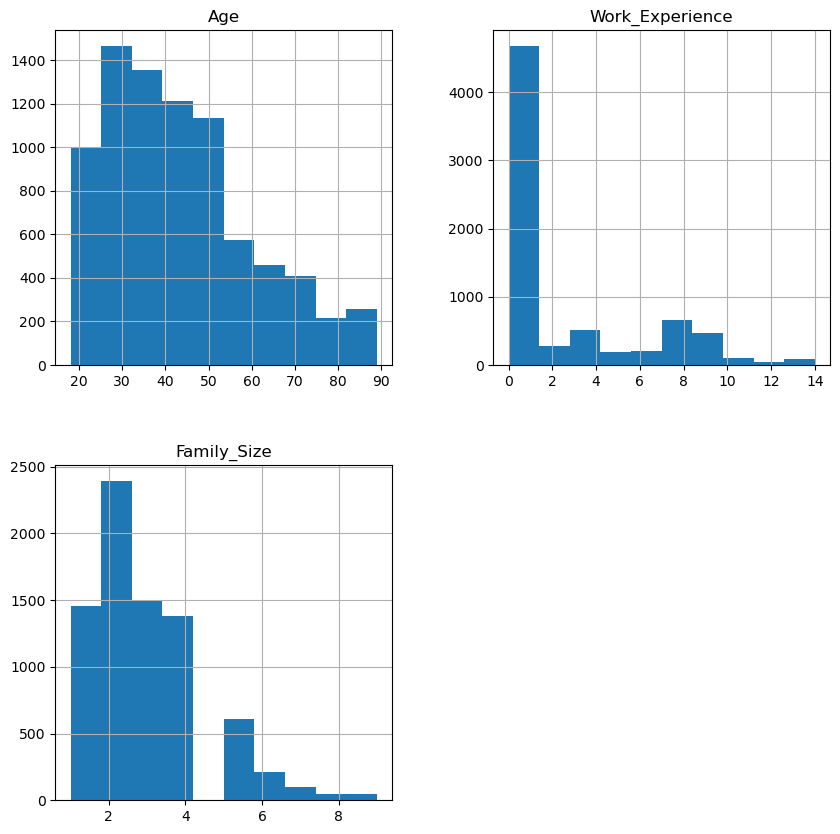

In [8]:
data.hist(figsize=(10, 10))
plt.show()

### As we can see, none of the numeric variables has a normal distribution,age looks like it has a little of the form with a right skew.

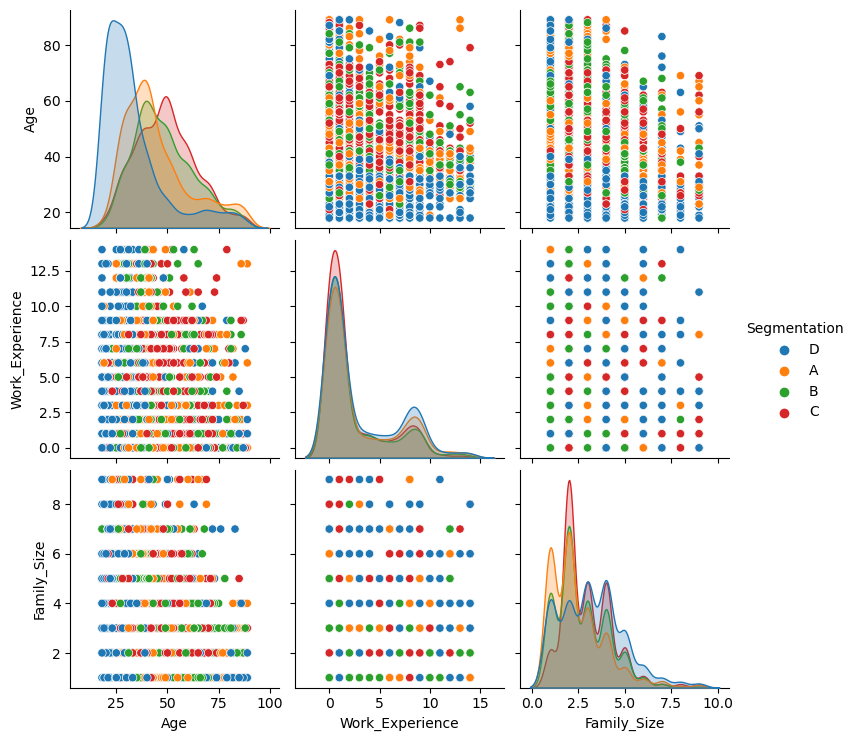

In [9]:
sns.pairplot(data, hue = 'Segmentation')
plt.show()

### This graphs don't relly help us, we should try other approaches, but first, lets drop all the entries with missing values.

In [10]:
data = data.dropna()

### Lets apply some scaling to see if we can get a clearer vision of the data.

In [11]:
scaled = data[['Age', 'Work_Experience', 'Family_Size']]
scaled = (scaled-scaled.mean())/data.std()
scaled['Segmentation'] = data['Segmentation']
scaled.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12084\4249999600.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  scaled = (scaled-scaled.mean())/data.std()


,Age,Work_Experience,Family_Size,Segmentation
0,-1.303317,-0.478394,0.760056,D
2,1.419985,-0.478394,-1.207489,B
3,1.419985,-0.772049,-0.551641,B
5,0.754289,-0.772049,-0.551641,C
6,-0.698139,-0.478394,0.104208,C


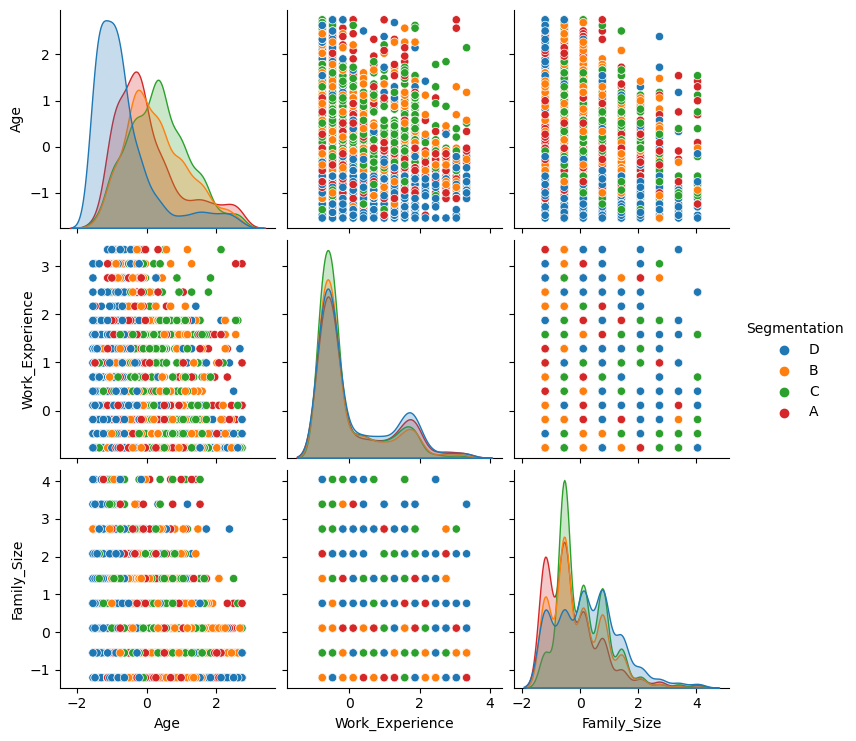

In [12]:
sns.pairplot(scaled, hue = 'Segmentation')
plt.show()

### At least in terms of visibility, there is no real change and we lost some interpretability, therefore, we stick with the original data.

### Time to get dummy variables to use feature selection.

In [13]:
# Encode the Segmentation variable as numeric
#segmentation_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
#data['Segmentation'] = data['Segmentation'].map(segmentation_mapping)
data = pd.get_dummies(data, columns = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1'])
data

,Age,Work_Experience,Family_Size,Segmentation,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,22,1.0,4.0,D,0,1,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,67,1.0,1.0,B,1,0,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
3,67,0.0,2.0,B,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
5,56,0.0,2.0,C,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
6,32,1.0,3.0,C,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,41,0.0,5.0,B,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
8064,35,3.0,4.0,D,0,1,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
8065,33,1.0,1.0,D,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
8066,27,1.0,4.0,B,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0


## We will try to do some predictions with the data the way it is. The reason for this, is because even if we do get a very good accuracy, as we transform more and more the data, we lose ability to interpret the data.

In [14]:
#KNN (Nearest-Neighbor)
cols_results=['family','model','classification_rate','runtime']
results = pd.DataFrame(columns=cols_results)

y = data['Segmentation']
X = data.drop('Segmentation', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)


kVals = 4
knn_names = 'KNN-4'

knn = KNeighborsClassifier(n_neighbors=kVals)
knn.fit(X_train, y_train)
        
time_start = time.time()
y_pred = knn.predict(X_test)
time_run = time.time()-time_start

knn_acc = accuracy_score(y_test,y_pred)


In [15]:
#Random Forest
r = 4
clf = RandomForestClassifier(n_estimators=int(math.pow(2,r)),random_state=0)
time_start = time.time()
clf.fit(X_train,y_train)
time_run = time.time()-time_start
y_pred=clf.predict(X_test)
        
rf_acc = accuracy_score(y_test,y_pred)


### Our results aren't great, we will try with Decision Tree.

In [16]:
tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
tree.fit(X_train, y_train)
DT_acc = accuracy_score(y_test, tree.predict(X_test))

### Now we will try a Logistic Regression

In [17]:
Log = LogisticRegression()
Log.fit(X_train, y_train)
LR_acc = accuracy_score(y_test, Log.predict(X_test))

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Naive Bayes

In [18]:
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_acc = accuracy_score(y_test, gnb.predict(X_test))


NameError: name 'gnb' is not defined